## Часть 2. Выбор и обоснование финальной модели для бинарной классификации

В рамках экспериментов решалась задача бинарной классификации направления цены на горизонте 5 торговых дней: предсказать, будет ли цена через 5 дней выше текущей. Были протестированы классические бустинги (CatBoost, XGBoost, LightGBM), их стэкинг, а также глубокие нейронные сети (CNN, GRU, LSTM, TFT). Оценивание проводилось на отложенной части выборки при хронологическом сплите и едином наборе признаков.

XGBoost оказался лучшим выбором, так как на отложенной выборке показал наивысшие значения по Accuracy, Precision и F1-score при сохранении высокого Recall. На мой взгляд, XGBoost оказался практичнее стэкинга и альтернативных моделей, потому что:

1. Даёт устойчивое качество на таких признаках, как технические индикаторы, рыночные данные, макроэкономические показатели, текстовые эмбеддинги.
2. Быстро обучается и предсказывает, не требует дополнительного мета-уровня, проще в поддержке.
3. Легко интерпретируется, что упрощает контроль и внедрение.

**Сводная таблица метрик:**

| Модель                          | Accuracy | Precision | Recall     | F1-score |
|---------------------------------|:--------:|:---------:|:----------:|:--------:|
| Ансамбль (Stacking XGB+CAT+LGB) | 0.7679   | 0.7729    | 0.7904     | 0.7815   |
| CatBoost                        | 0.7872   | 0.7807    | 0.8272     | 0.8033   |
| CNN                             | 0.7720   | 0.7994    | 0.7754     | 0.7872   |
| GRU                             | 0.7406   | 0.7249    | **0.8443** | 0.7801   |
| LightGBM                        | 0.7708   | 0.7851    | 0.7762     | 0.7806   |
| LSTM                            | 0.7031   | 0.7923    | 0.6168     | 0.6936   |
| TFT                             | 0.7683   | 0.7500    | 0.6364     | 0.6885   |
| XGBoost                         | **0.7961** | **0.8000** | 0.8159     | **0.8079** |

Таким образом, XGBoost выбран в качестве финальной модели для бинарной классификации направления цены на горизонте 5 дней: он обеспечивает лучший общий баланс точности, полноты и итогового F1, не усложняет пайплайн и остаётся удобным для интерпретации и эксплуатации.

#### Блок 1: Импорты, пути и SEED

In [3]:
import os
import joblib
import optuna
import xgboost as xgb
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

SEED = 42
np.random.seed(SEED)

BASE_DIR = r"C:\VKR_Almaz_Mamatov\VKR_Almaz_Mamatov_DS_16\Part_2\XGBoost"
DATA_PATH = r"C:\VKR_Almaz_Mamatov\VKR_Almaz_Mamatov_DS_16\Part_2\df_catboost_BIN.csv" # берем готовый ДФ подходящий для моделей бустинга
MODEL_PATH = os.path.join(BASE_DIR, "xgb_model_BIN.json")
STUDY_PATH = os.path.join(BASE_DIR, "optuna_study_BIN.pkl")

os.makedirs(BASE_DIR, exist_ok=True)
print("Блок 1 готов:", BASE_DIR)

Блок 1 готов: C:\Users\Администратор\Desktop\Аналитик данных\Дипломная работа\DL\Бинарная классификация\XGBoost


#### Блок 2: Загрузка готового ДФ и тайм-сплит 80/20 (без переподготовки признаков)

ДФ для обучения XGBoost подготовлен так, чтобы не «подглядывать в будущее» и не тянуть в модель утечки (ДФ был подготовлен при обучении модели CatBoost и переиспользован).

Для подготовки корректного ДФ были выполнены следующие операции:

1. Загружаем данные, приводим date к datetime, сортируем по дате и убираем дубликаты дат.
2. Строим бинарный таргет: 1, если цена через 5 дней выше текущей, иначе 0.
3. Добавляем простые календарные признаки: month, day_of_week, is_weekend.
4. Приводим текстовые числа к числам: проценты (“change %”) → float, объём (“vol.”) с K/M/B → абсолютные значения.
5. Все ценовые, объёмные, технические и кросс-рыночные признаки сдвигаем вперёд на +5 строк, чтобы на каждой дате были доступны только «исторические» значения.
6. Удаляем хвост без таргета и строки с пропусками, появившимися после сдвига.
7. По train-части (~80 % первых строк) считаем корреляции с таргетом и отбрасываем признаки с |corr| > 0.90.
8. Формируем финальный список признаков, отдельно отмечаем категориальные (month, day_of_week, is_weekend).
9. Сохраняем итоговый ДФ и списки признаков; делим по времени 80/20 и используем ровно эти колонки в XGBoost.

Дальше этим же подготовленным ДФ (df_catboost_BIN.csv) настраиваем входы для XGBoost:

1. Считываем файл, сортируем по дате и сбрасываем индексы.
2. Исключаем служебные поля — date, target_5d_dir, group_id, time_idx — всё остальное идёт в feature_cols.
3. Делим по времени 80/20 без перемешивания: train — ранний участок ряда, test — более поздний.
4. Формируем матрицы и целевые признаки: X_train/X_test из feature_cols, метки y_train/y_test берём из target_5d_dir и приводим к int.
5. Для ранней остановки выделяем валидацию из «хвоста» train: последние 15 % идут в X_val/y_val, всё до этого — X_tr/y_tr; тест не трогаем.
6. Упаковываем выборки в DMatrix (dtrain, dvalid, dtrain_full, dtest) — это родной формат XGBoost с сохранением имён признаков.
7. Проверяем баланс классов в train и считаем scale_pos_weight = neg/pos (учитываем оба класса; если один из классов отсутствует — выбрасываем ошибку).
8. Выводим сводку по размеру train и соотношению классов — для контроля перед обучением.

In [4]:
df = pd.read_csv(DATA_PATH, parse_dates=["date"]).sort_values("date").reset_index(drop = True)
    
# Логика такая же, как у CatBoost-версии: исключаем служебные столбцы
reserved = {"date", "target_5d_dir", "group_id", "time_idx"}
feature_cols = [c for c in df.columns if c not in reserved]
    
split_idx = int(len(df) * 0.80)
train = df.iloc[:split_idx].reset_index(drop=True)
test = df.iloc[split_idx:].reset_index(drop=True)
    
X_train, y_train = train[feature_cols], train["target_5d_dir"].astype(int).values
X_test,  y_test = test[feature_cols],  test["target_5d_dir"].astype(int).values
    
# Валидация из хвоста train (для ранней остановки, test не трогаем)
val_frac = 0.15
val_idx = int(len(X_train) * (1 - val_frac))
X_tr, y_tr = X_train.iloc[:val_idx], y_train[:val_idx]
X_val, y_val = X_train.iloc[val_idx:], y_train[val_idx:]
    
# DMatrix для XGBoost
dtrain = xgb.DMatrix(X_tr,  label = y_tr,  feature_names = feature_cols)
dvalid = xgb.DMatrix(X_val, label = y_val, feature_names = feature_cols)
dtrain_full = xgb.DMatrix(X_train, label = y_train, feature_names = feature_cols)
dtest = xgb.DMatrix(X_test,  label = y_test,  feature_names = feature_cols)
    
# Баланс классов
pos = (y_train == 1).sum()
neg = (y_train == 0).sum()
if pos == 0 or neg == 0:
    raise ValueError("В train присутствует только один класс. Нужны оба класса.")
scale_pos_weight = neg / max(pos, 1)
print(f"Train size: {len(y_train)} | pos = {pos} neg = {neg} | scale_pos_weight = {scale_pos_weight:.3f}")

Train size: 2685 | pos = 1404 neg = 1281 | scale_pos_weight = 0.912


#### Блок 3: Optuna (валидация из хвоста train, ранняя остановка в xgb.train)

В данном блоке кода мы настраиваем и подбираем гиперпараметры XGBoost с помощью Optuna для бинарной классификации направления цены. Цель — найти такие настройки, при которых ошибка на валидации (logloss) будет минимальной, а обучение — устойчивым и не переобученным.

В данном блоке мы выполняем следующие операции:

1. Задаём целевую функцию для Optuna: фиксируем базовые параметры XGBoost (`objective="binary:logistic"`, `eval_metric="logloss"`, `tree_method="hist"`, `seed`) и описываем пространство поиска — скорость обучения `eta`, глубину `max_depth`, минимальный вес листа `min_child_weight`, доли подвыборки `subsample` и `colsample_bytree`, регуляризации `gamma`, `lambda`, `alpha`, а также число деревьев `n_estimators`.
2. Учитываем дисбаланс классов через заранее посчитанный `scale_pos_weight`, чтобы модель не «тянула» к более частому классу.
3. Для каждого прогона (trial) Optuna обучаем XGBoost на тренировочной части (`dtrain`) и контролируем качество на валидации (`dvalid`), включая раннюю остановку `early_stopping_rounds=75`, чтобы не крутить лишние итерации без улучшений.
4. Берём лучший достигнутый `valid-logloss` у модели и отдаём его Optuna как значение целевой функции — чем меньше, тем лучше.
5. Настраиваем Optuna: используем TPE-семплер (случайный, но управляемый сидом) и pruner по медиане, чтобы отсекать слабые варианты раньше и ускорить поиск.
6. Запускаем оптимизацию с ограничениями по числу попыток и времени, после чего сохраняем найденное исследование (`study`) на диск и печатаем лучшие параметры — их будем использовать для финального обучения.

Таким образом, на выходе мы получаем воспроизводимый набор лучших гиперпараметров XGBoost (минимальный `valid-logloss`), с учётом дисбаланса классов и защитой от переобучения за счёт ранней остановки и pruner’а. Сохранённый `study` — это источник лучших настроек для финального дообучения на `train+val` и последующего инференса.

In [4]:

def objective(trial):
    params = {
        "objective": "binary:logistic",
        "eval_metric": "logloss",          # минимизируем logloss на валидации
        "seed": SEED,
        "tree_method": "hist",             # быстрее и детерминированнее
        "eta": trial.suggest_float("eta", 0.01, 0.20, log = True),
        "max_depth": trial.suggest_int("max_depth", 3, 8),
        "min_child_weight": trial.suggest_float("min_child_weight", 1.0, 10.0),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "gamma": trial.suggest_float("gamma", 0.0, 5.0),
        "lambda": trial.suggest_float("lambda", 1e-3, 10.0, log = True),
        "alpha": trial.suggest_float("alpha", 1e-3, 5.0, log = True),
        "scale_pos_weight": scale_pos_weight,
    }
    num_boost_round = trial.suggest_int("n_estimators", 200, 700)

    evals_result = {}
    model = xgb.train(
        params = params,
        dtrain = dtrain,
        num_boost_round = num_boost_round,
        evals = [(dtrain, "train"), (dvalid, "valid")],
        early_stopping_rounds = 75,
        verbose_eval = False,
        evals_result = evals_result,
    )

    best_logloss = float(model.best_score)  # valid-logloss
    return best_logloss

sampler = optuna.samplers.TPESampler(seed = SEED, n_startup_trials = 8)
pruner = optuna.pruners.MedianPruner(n_startup_trials = 8, n_warmup_steps = 2)
study = optuna.create_study(direction = "minimize", sampler = sampler, pruner = pruner)

study.optimize(objective, n_trials = 25, timeout = 900, show_progress_bar = False, gc_after_trial = True)
joblib.dump(study, STUDY_PATH)
print("Best Optuna params:", study.best_params)


[I 2025-08-11 18:15:24,135] A new study created in memory with name: no-name-eae56266-6fd7-4d95-b2fb-72db3fed8ad3
[I 2025-08-11 18:15:31,452] Trial 0 finished with value: 0.5329769119786714 and parameters: {'eta': 0.030710573677773714, 'max_depth': 8, 'min_child_weight': 7.587945476302646, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'gamma': 0.7799726016810132, 'lambda': 0.0017073967431528124, 'alpha': 1.599409170128044, 'n_estimators': 501}. Best is trial 0 with value: 0.5329769119786714.
[I 2025-08-11 18:15:33,464] Trial 1 finished with value: 0.5321709178665436 and parameters: {'eta': 0.08341106432362087, 'max_depth': 3, 'min_child_weight': 9.72918866945795, 'subsample': 0.9329770563201687, 'colsample_bytree': 0.6849356442713105, 'gamma': 0.9091248360355031, 'lambda': 0.00541524411940254, 'alpha': 0.01334697757417809, 'n_estimators': 462}. Best is trial 1 with value: 0.5321709178665436.
[I 2025-08-11 18:15:37,717] Trial 2 finished with value: 0.533155669

Best Optuna params: {'eta': 0.01892464555385131, 'max_depth': 7, 'min_child_weight': 9.70977925844086, 'subsample': 0.9587663995768833, 'colsample_bytree': 0.9017511018096211, 'gamma': 4.5028006574514166, 'lambda': 3.4157695009644202, 'alpha': 0.005540476725642567, 'n_estimators': 660}


#### Блок 4: Финальное обучение на всём train с валидацией из хвоста train

В данном блоке кода мы финализируем XGBoost для бинарной классификации (направления цены на горизонте 5 дней) и сохраняем готовую модель для дальнейшего использования.

В данном блоке мы выполняем следующие операции:

1. Берём лучшие гиперпараметры из Optuna и собираем финальный конфиг: фиксируем задачу `binary:logistic`, метрику контроля `logloss`, сид, быстрый режим обучения деревьев (`hist`) и коэффициент балансировки классов `scale_pos_weight`. Для надёжности подставляем разумные значения по умолчанию, если чего-то нет в `best_params`.
2. Определяем максимальное число итераций (деревьев) из найденного `n_estimators`.
3. Обучаем модель на всей обучающей части (`dtrain_full`), но продолжаем следить за качеством по валидации (`dvalid`) и включаем раннюю остановку: если `logloss` не улучшается 100 шагов, обучение останавливается на лучшей найденной итерации.
4. Фиксируем номер лучшей итерации (`best_iteration`) — это точка, где модель показала минимальный валидационный `logloss`.
5. Сохраняем получившуюся модель на диск по указанному пути, чтобы использовать её для предсказания без повторного обучения.

В результате получаем финально настроенный XGBoost с оптимальными параметрами и ранней остановкой на лучшем шаге. Модель сохранена в файл и готова к применению в прогнозе.

In [5]:
best_params = joblib.load(STUDY_PATH).best_params.copy()
final_params = {
    "objective": "binary:logistic",
    "eval_metric": "logloss",
    "seed": SEED,
    "tree_method": "hist",
    "eta": best_params.get("eta", 0.1),
    "max_depth": best_params.get("max_depth", 6),
    "min_child_weight": best_params.get("min_child_weight", 1.0),
    "subsample": best_params.get("subsample", 0.8),
    "colsample_bytree": best_params.get("colsample_bytree", 0.8),
    "gamma": best_params.get("gamma", 0.0),
    "lambda": best_params.get("lambda", 1.0),
    "alpha": best_params.get("alpha", 0.0),
    "scale_pos_weight": scale_pos_weight,
}

num_boost_round = best_params.get("n_estimators", 500)

model = xgb.train(
    params = final_params,
    dtrain = dtrain_full,
    num_boost_round = num_boost_round,
    evals = [(dtrain_full, "train"), (dvalid, "valid")],
    early_stopping_rounds = 100,
    verbose_eval = 50
)

best_iter = model.best_iteration
print("Best iteration:", best_iter)

model.save_model(MODEL_PATH)
print("Модель сохранена:", MODEL_PATH)

[0]	train-logloss:0.68656	valid-logloss:0.68676
[50]	train-logloss:0.50567	valid-logloss:0.50731
[100]	train-logloss:0.43225	valid-logloss:0.42910
[150]	train-logloss:0.38859	valid-logloss:0.37833
[200]	train-logloss:0.35921	valid-logloss:0.34225
[250]	train-logloss:0.34371	valid-logloss:0.32247
[300]	train-logloss:0.33759	valid-logloss:0.31609
[350]	train-logloss:0.33650	valid-logloss:0.31494
[400]	train-logloss:0.33551	valid-logloss:0.31393
[450]	train-logloss:0.33351	valid-logloss:0.31164
[500]	train-logloss:0.33235	valid-logloss:0.31042
[550]	train-logloss:0.33193	valid-logloss:0.30980
[600]	train-logloss:0.33183	valid-logloss:0.30964
[650]	train-logloss:0.33168	valid-logloss:0.30905
[659]	train-logloss:0.33163	valid-logloss:0.30902
Best iteration: 659
Модель сохранена: C:\Users\Администратор\Desktop\Аналитик данных\Дипломная работа\DL\Бинарная классификация\XGBoost\xgb_model_BIN.json


**Выводы**

1. logloss на валидации уверенно снижается по мере роста числа деревьев, и обучение не переобучается слишком рано.
2. Минимум валидационного logloss достигнут на 659-й итерации, после чего улучшения перестали быть значимыми. Именно это значение и зафиксировано как best_iteration.
3. Разрыв между train-logloss и valid-logloss небольшой (0.3316 vs 0.3090), что говорит об отсутствии сильного переобучения — модель обучилась стабильно.
4. Использование ранней остановки позволило избежать «достройки» лишних деревьев и сохранить модель в оптимальной точке.
5. В итоге получена финальная модель XGBoost для бинарной классификации направления цены с оптимальными гиперпараметрами, сохранённая в файл для дальнейших прогнозов.

Таким образом, модель показала хорошую сходимость и сбалансированное качество на обучении и валидации, а сохранённый чекпоинт можно использовать для оценки на тесте и в дальнейшем продакшн-применении.

#### Блок 5: Проверка баланса классов в выборках

В данном блоке мы анализируем распределение целевого признака (0 и 1) в разных выборках — train, validation и test. Это важно для понимания, сбалансированы ли данные, и можно ли доверять метрике Accuracy без риска, что она будет «подтянута» за счёт доминирования одного класса.

В данном блоке мы выполняем следующие операции:

1. Для каждой из выборок считаем количество объектов класса 0 и класса 1.
2. Вычисляем долю каждого класса в процентах.
3. Выводим результаты в удобочитаемом виде, чтобы сразу увидеть, сбалансированы ли данные.

В результате мы получаем «срез» по распределению классов. В связи с тем, что классы примерно равны, можно спокойно использовать Accuracy как целевую метрику. Если бы наблюдался сильный перекос (например, 80% против 20%), потребовалось бы ориентироваться на более устойчивые метрики вроде F1.

In [6]:
def show_balance(name, y):
    counts = pd.Series(y).value_counts().sort_index()
    ratio = counts / counts.sum()
    print(f"\n{name}:")
    for cls, cnt in counts.items():
        print(f"  Класс {cls}: {cnt} ({ratio[cls]*100:.2f}%)")

show_balance("Train", y_train)
show_balance("Validation", y_val)
show_balance("Test", y_test)


Train:
  Класс 0: 1281 (47.71%)
  Класс 1: 1404 (52.29%)

Validation:
  Класс 0: 201 (49.88%)
  Класс 1: 202 (50.12%)

Test:
  Класс 0: 319 (47.47%)
  Класс 1: 353 (52.53%)


#### Блок 6: Оценка на тесте и графики

В данном блоке мы оцениваем уже обученный XGBoost на отложенной части данных и наглядно показываем, где модель попадает и промахивается.

В данном блоке мы выполняем следующие операции:

1. Сначала получаем для каждой тестовой даты вероятность класса 1. Вызов с `iteration_range=(0, model.best_iteration + 1)` фиксирует именно тот объём деревьев, который модель нашла оптимальным на валидации — без «достройки» после точки ранней остановки.
2. Переводим вероятности в метки по порогу 0.5. Это базовый порог: всё, что ≥ 0.5 — «рост», иначе — «падение».
3. Считаем полный набор метрик:  
   3.1. **Accuracy** — доля верных ответов.  
   3.2. **Precision** — насколько «чистые» наши срабатывания на «рост».  
   3.3. **Recall** — сколько реальных «ростов» мы поймали.  
   3.4. **F1** — общий баланс точности и полноты.
4. Готовим ось времени: берём даты из тестовой части. Если по какой-то причине колонки *date* нет, используем просто индексы — чтобы график всё равно отрисовался.
5. Строим график «факт vs прогноз» по датам. Кружки — истинный класс на каждую дату, крестики — прогноз. Добавляем небольшой вертикальный шум (*jitter*), чтобы точки не закрывали друг друга и можно было глазами увидеть, где модель совпадает с фактом, а где расходится.
6. Строим и выводим матрицу ошибок. По ней видно, каких промахов больше:  
   6.1. Ложно-положительные (спутали «падение» с «ростом») — верхняя правая ячейка.  
   6.2. Ложно-отрицательные (пропустили «рост») — нижняя левая.

В результате получаем «срез» качества модели на тесте в цифрах и наглядных графиках. В результате получаем «срез» качества модели на тесте в цифрах и наглядных графиках. Так как классы сбалансированы примерно 50/50, базовый порог 0.5 является хорошим и устойчивым выбором — он обеспечивает оптимальный баланс между Precision и Recall без необходимости дополнительного смещения.

Test Accuracy:  0.7961
Test Precision: 0.8000
Test Recall:    0.8159
Test F1-score:  0.8079


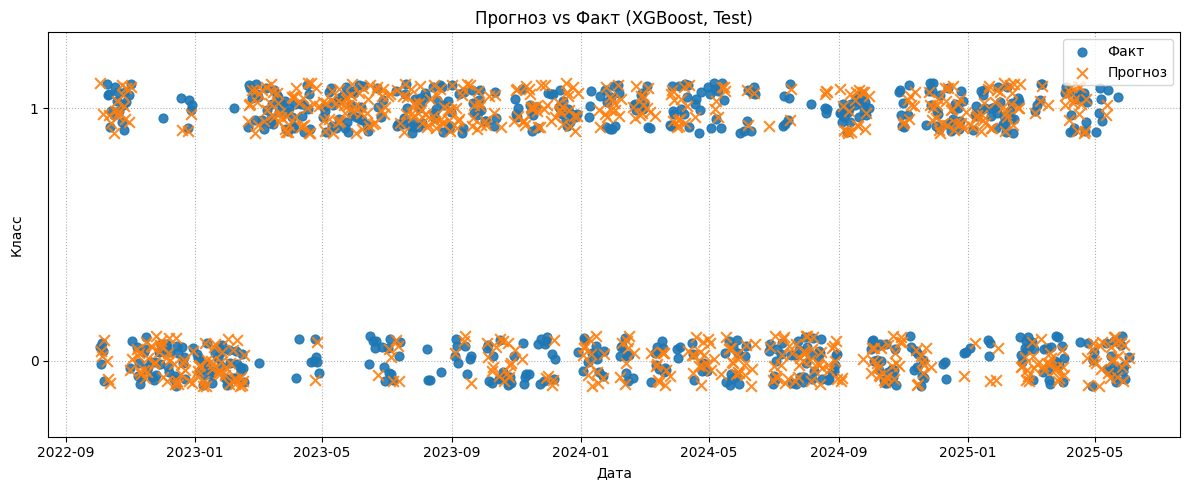

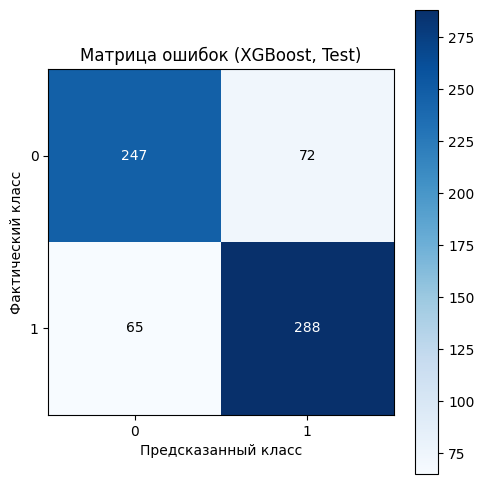

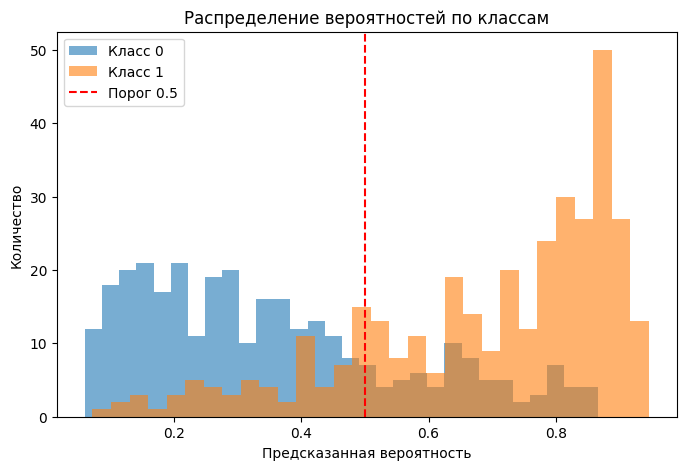

In [19]:
y_proba = model.predict(dtest, iteration_range = (0, model.best_iteration + 1))
y_pred = (y_proba >= 0.5).astype(int)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec  = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Test Accuracy:  {acc:.4f}")
print(f"Test Precision: {prec:.4f}")
print(f"Test Recall:    {rec:.4f}")
print(f"Test F1-score:  {f1:.4f}")

# Даты и классы
dates = pd.to_datetime(test["date"].values) if "date" in test.columns else np.arange(len(y_test))
y_true = np.asarray(y_test).astype(int)
y_hat = np.asarray(y_pred).astype(int)

# Небольшой вертикальный шум (jitter), чтобы точки не перекрывались
rng = np.random.default_rng(42)
jitter = 0.10  # амплитуда шума в долях класса
y_true_j = y_true + rng.uniform(-jitter, jitter, size = len(y_true))
y_hat_j = y_hat  + rng.uniform(-jitter, jitter, size = len(y_hat))

# График: точки = факт, крестики = прогноз (с шумом)
plt.figure(figsize=(12, 5))
plt.scatter(dates, y_true_j, marker = 'o', s = 40, label = 'Факт', alpha = 0.9, zorder = 2)
plt.scatter(dates, y_hat_j,  marker = 'x', s = 60, label = 'Прогноз', alpha = 0.9, zorder = 3)
plt.yticks([0, 1], ['0', '1'])
plt.ylim(-0.3, 1.3)
plt.title("Прогноз vs Факт (XGBoost, Test)")
plt.xlabel("Дата")
plt.ylabel("Класс")
plt.legend()
plt.grid(True, linestyle=":")
plt.tight_layout()
plt.show()

# Матрица ошибок
fig, ax = plt.subplots(figsize = (5, 5))
im = ax.imshow(cm, interpolation = "nearest", cmap = plt.cm.Blues)
ax.set_title("Матрица ошибок (XGBoost, Test)")
plt.colorbar(im, ax=ax)

ax.set_xticks([0, 1]); ax.set_xticklabels(["0", "1"])
ax.set_yticks([0, 1]); ax.set_yticklabels(["0", "1"])
ax.set_xlabel("Предсказанный класс")
ax.set_ylabel("Фактический класс")

thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, str(cm[i, j]),
                ha = "center", va = "center",
                color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()


plt.figure(figsize=(8,5))
plt.hist(y_proba[y_test==0], bins=30, alpha=0.6, label="Класс 0")
plt.hist(y_proba[y_test==1], bins=30, alpha=0.6, label="Класс 1")
plt.axvline(0.5, color="red", linestyle="--", label="Порог 0.5")
plt.xlabel("Предсказанная вероятность")
plt.ylabel("Количество")
plt.title("Распределение вероятностей по классам")
plt.legend()
plt.show()


**Выводы**

**Метрики**
- **Accuracy = 0.7961** — почти 80% предсказаний совпадают с фактом.  
- **Precision = 0.8000** — среди предсказанных «ростов» 80% оказались реальными ростами.  
- **Recall = 0.8159** — модель поймала 81.6% всех фактических ростов.  
- **F1 = 0.8079** — хороший баланс между точностью и полнотой, что говорит о том, что модель одновременно умеет находить большинство реальных ростов и при этом достаточно редко ошибается ложными сигналами.  

Совокупно метрики показывают стабильное качество: модель не «перекошена» ни в Precision, ни в Recall.

**График «Прогноз vs Факт»**
1. Точки = фактический класс по датам, крестики = прогноз.  
2. Видно, что большая часть прогнозов совпадает с фактами (крестики накладываются на кружки).  

Ошибки распределены по времени относительно равномерно, нет участков, где модель полностью «сломалась».

**Матрица ошибок**
- **TN = 247** — верно определённые «падения».  
- **TP = 288** — верно определённые «росты».  
- **FP = 72** — предсказали «рост», а было падение.  
- **FN = 65** — пропустили рост, предсказав падение.  

Ошибки FP и FN распределены примерно одинаково, что подтверждает баланс между Precision и Recall: модель не склонна явно смещаться ни в сторону лишних ложных срабатываний, ни в сторону пропуска сигналов, то есть одинаково хорошо удерживает чистоту прогнозов и полноту обнаружения реальных ростов.


**Гистограмма распределения вероятностей**
1. Для класса **0 (падение)** большинство предсказаний сосредоточено в диапазоне **0.1–0.4**, то есть модель уверенно считает их «не ростом».  
2. Для класса **1 (рост)** значения в основном лежат в области **0.6–0.9**, что говорит об уверенных прогнозах на «рост».  
3. В районе порога **0.5** распределения пересекаются — именно здесь модель чаще всего ошибается.  

Модель хорошо различает рост и падение, но в «пограничной зоне» около 0.5 её уверенность минимальна, и именно там возникают ошибки.

#### Блок 7: Прогноз для конкретной даты

В данном блоке кода мы делаем точечный прогноз направления на конкретную дату, используя уже обученный XGBoost и тот же подготовленный ДФ, что и на этапе обучения. Важно, что мы подаём в модель ровно те же признаки и в том же порядке, чтобы избежать расхождений.

В данном блоке мы выполняем следующие операции:

1. Загружаем финальный ДФ и обученный бустер XGBoost из файла.
2. Синхронизируем список признаков: берём `booster.feature_names`; если в модели имена не сохранены, используем заранее зафиксированный список `feature_cols`.
3. Отбираем одну строку по дате запроса (`2025-06-02`). Если строки нет — явно сообщаем об ошибке.
4. Формируем матрицу `DMatrix` только из нужных признаков в правильном порядке и передаём её в модель.
5. Получаем вероятность класса 1 (рост), переводим её в бинарный прогноз по порогу 0.5 и выводим результат в человекочитаемом виде.
6. Если в строке уже есть фактический таргет `target_5d_dir`, выводим для сравнения фактическое направление.

В результате на входе — дата и подготовленный ДФ, на выходе — вероятность роста и бинарный прогноз («рост»/«падение») с возможной проверкой на факте, если он доступен.

In [21]:
# Загружаем тот же готовый ДФ и модель
df_all = pd.read_csv(DATA_PATH, parse_dates = ["date"]).sort_values("date")
booster = xgb.Booster()
booster.load_model(MODEL_PATH)

feat_names = booster.feature_names
if feat_names is None:
    feat_names = feature_cols  # fallback

query_date = pd.to_datetime("2025-06-02")
row = df_all[df_all["date"] == query_date]
if row.empty:
    raise ValueError(f"В данных нет строки за {query_date.date()}")

X_input = row[feat_names]
dmatrix = xgb.DMatrix(X_input, feature_names = feat_names)

proba = float(booster.predict(dmatrix)[0])
pred_class = int(proba >= 0.5)

print(f"Дата: {query_date.date()}")
print(f"Вероятность класса 1 (рост): {proba:.4f}")
print(f"Прогноз направления: {'рост' if pred_class == 1 else 'падение'}")

# При наличии факта в строке
if "target_5d_dir" in row.columns and not pd.isna(row["target_5d_dir"].iloc[0]):
    fact = int(row["target_5d_dir"].iloc[0])
    print(f"Фактическое направление: {'рост' if fact == 1 else 'падение'}")

Дата: 2025-06-02
Вероятность класса 1 (рост): 0.1164
Прогноз направления: падение
Фактическое направление: падение


**Вывод**

В результате точечного прогноза для даты **2025-06-02**:

- **Вероятность роста через 5 дней** = 0.1164  
- **Прогноз направления через 5 дней**: падение  
- **Фактическое направление через 5 дней**: падение  

Модель попала в цель: предсказание совпало с реальностью.  

Такие проверки на отдельных датах удобны для «ручной валидации» — они позволяют глазами убедиться, что модель адекватно реагирует на конкретные исторические ситуации, и служат наглядной демонстрацией работы модели.

## **Выводы по выбору и обоснованию финальной модели для бинарной классификации**

### Сравнение с другими исследованиями

В таблице собраны исследования, близкие к моей задаче — предсказание направления цены на горизонте **5 торговых дней**.  
Указаны рынки, модели и достигнутые метрики.

#### Сводная таблица

| Работа | Рынок | Горизонт | Модель | Метрики | Результат | Комментарий |
|---|---|---|---|---|---|---|
| **Моя модель (XGBoost)** | Акции (тех. индикаторы, макро, новости) | **5 дней** | XGBoost | Accuracy / Precision / Recall / F1 | **0.796 / 0.800 / 0.816 / 0.808** | Почти 80% точности, сбалансированные классы |
| Sadorsky (2021) | ETF золото и серебро | 5–20 дней | Bagging, Random Forests, SGB, Logit | Accuracy | Logit ≤0.60; RF/Bagging ~0.80–0.90 | Простая регрессия слабая, ансамбли деревьев достигают до 90% |
| Basher & Sadorsky (2022) | Биткоин, золото | 5–20 дней | Random Forests, Bagging | Accuracy | 5 дней: ~0.75–0.80; 15–20 дней: >0.90 | Макро + тех. индикаторы, на длинных горизонтах точность очень высокая |
| Yıldırım et al. (2021) | Forex (EUR/USD) | 5 дней | LSTM (макро + тех) | Profit accuracy | Базовые LSTM: ~0.45–0.50; гибрид: ~0.79–0.84 | Гибрид с фильтрацией сигналов даёт высокую точность, но не на всех датах |
| Хубиев & Семёнов (2025) *(Россия)* | MOEX, акции + новости | 5 дней | LSTM, XGBoost | Accuracy | LSTM ~0.52; XGB ~0.45 | Использование новостей снижает MAPE, но по Accuracy результаты средние |
| ВКР НИУ ВШЭ (2025) *(Россия)* | MOEX, 15 акций | t+1 (направление) | LSTM + отбор признаков Boruta | Accuracy / Precision / Recall / F1 | ~0.58–0.66 Accuracy | Для разных тикеров и окон результаты варьируются, но стабильно выше случайного угадывания |



#### Подробное описание исследований

- **Sadorsky (2021)**  
  Исследовал прогноз направления цен на ETF золота и серебра. Использовались 13 технических индикаторов (RSI, MACD, MA и др.). Сравнивались logit, bagging, random forests и стохастический градиентный бустинг.  
  Результаты: logit показывал не выше 55–60%, в то время как RF и bagging достигали 80–90% на горизонтах 10–20 дней.  

- **Basher & Sadorsky (2022)**  
  Аналогичный анализ, но для Bitcoin и золота. Модели: RF и bagging.  
  Использовались технические индикаторы (MA, MACD, RSI, OBV) и макроэкономика (VIX, OVX, доходности облигаций, инфляция).  
  На 5-дневном прогнозе деревья давали Accuracy 75–80%, а на горизонтах 15+ дней — выше 90%.  
  Также отмечено, что макропеременные усиливают модель, но ключевыми остаются технические индикаторы.

- **Yıldırım et al. (2021)**  
  Прогноз направления валютной пары EUR/USD. Построены две LSTM: одна обучалась на макроэкономических данных, другая — на технических индикаторах.  
  Базовые модели давали около 45–50% точности.  
  Авторы предложили rule-based объединение сигналов: модель делала прогноз только если оба LSTM уверены. В этом случае «profit accuracy» поднималась до 79–84%, но прогнозировались лишь около 40% всех дат.

- **Хубиев & Семёнов (2025) *(Россия)***  
  Работа посвящена прогнозу на MOEX с использованием LSTM, XGBoost и новостных эмбеддингов (RuBERT, Qwen).  
  Результаты оказались скромными: Accuracy около 0.52 у LSTM и ~0.45 у XGBoost.  
  Авторы отмечают, что добавление новостей снижает ошибку MAPE, однако по Accuracy модели остаются ниже ансамблей деревьев.

- **ВКР НИУ ВШЭ (2025) *(Россия)***  
  Студенческая работа по 15 акциям MOEX. Использовались LSTM с отбором признаков методом Boruta.  
  Метрики на горизонте t+1: Accuracy ~0.58–0.66 (в зависимости от тикера и окна), Precision и Recall также варьировались.  
  Результаты стабильно выше случайного угадывания, но уступают ансамблям деревьев и гибридным моделям.



#### Ссылки на статьи

- Sadorsky, P. (2021). *Predicting gold and silver price direction using tree-based classifiers*.  
  [Journal of Risk and Financial Management (MDPI)](https://www.mdpi.com/1911-8074/14/5/198)  

- Basher, S., & Sadorsky, P. (2022). *Forecasting Bitcoin and gold price direction with tree-based classifiers*.  
  [MPRA (PDF)](https://mpra.ub.uni-muenchen.de/113293/1/MPRA_paper_113293.pdf)  

- Yıldırım, S., et al. (2021). *A hybrid LSTM and rule-based approach for forecasting EUR/USD exchange rate direction*.  
  [Financial Innovation (SpringerOpen)](https://jfin-swufe.springeropen.com/articles/10.1186/s40854-020-00220-2)  

- Хубиев, А., & Семёнов, В. (2025). *Прогноз направления цен на акциях MOEX с использованием RuBERT и XGBoost*.  
  [PSTA](https://psta.psiras.ru/read/psta2025_1_83-130.pdf)  

- ВКР НИУ ВШЭ (2025). *Прогнозирование направления движения акций MOEX на горизонте t+1 с помощью LSTM*.  
  [Аннотация с результатами в каталоге ВКР HSE](https://www.hse.ru/edu/vkr/1047838899)  



#### Итоговый вывод

В сравнении с существующими исследованиями моя модель XGBoost на горизонте **5 торговых дней** показывает себя довольно уверенно.  
Если простые модели вроде логистической регрессии редко выходят за рамки **55–60% точности**, а базовые LSTM колеблются в районе **50–66%**, то ансамбли деревьев (Random Forest, Bagging) стабильно достигают **75–80%** на том же горизонте.  
Гибридные LSTM в отдельных случаях могут дать до **80%+**, но они прогнозируют не на всех датах.  

Моя модель XGBoost с результатом **Accuracy ≈0.80 и F1 ≈0.81** сопоставима с лучшими ансамблями деревьев и превосходит большинство решений на LSTM, при этом она работает **на каждой дате без фильтрации сигналов**.  
Это позволяет считать её результат конкурентоспособным и практически значимым для задач прогноза цен на горизонте t+5.